In [1]:
# Set up interactive plotting using matplotlib, and load numpy
# %pylab ipympl
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Import PODPAC dependencies

In [2]:
from collections import OrderedDict
import podpac
from podpac.datalib import smap

# Provide Earth Data Login Credentials
If you do not have an earth data login, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html)

In [3]:
import getpass
username = input("Username:");   password = getpass.getpass('Password:')

# Create the PODPAC SMAP Node, selecting the Sentinel product

In [4]:
# Create the SMAP node
product = 'SPL2SMAP_S.001'   # Level 2 SMAP-Sentinel Data
sm = smap.SMAP(product=product, interpolation='nearest', username=username, password=password)

# Retrieve and plot SMAP data for:
## * A particular date
## * Over lat-lon range with user-specified grid

In [5]:
# !!! This takes quite a while since it retrieves data from a lot of tiles (100's)
c_world = podpac.Coordinate(#dim=(start, stop, step)
                             lat=(   90,  -90,-0.5),
                             lon=( -180,  180, 0.5), 
                             time=['2018-05-19T12:00:00', '2018-05-20T12:00:00'])
sm.interpolation = 'nearest_preview'
o = sm.execute(c_world)


(-180.25, 180.25, -90.25, 90.25)

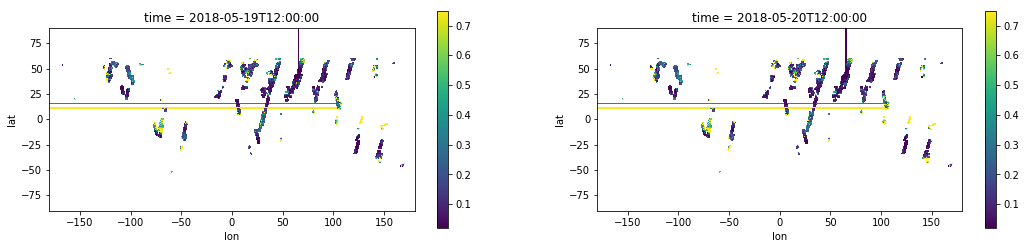

In [6]:
figure(figsize=(18, 4))
subplot(121);o[..., 0].plot(); axis('scaled')
subplot(122);o[..., 1].plot(); axis('scaled')

# Figure out how often a tile is available for each 1°x1° square of the earth
# While doing that, also find pairs of tiles that overlap for the same date/time/area

In [7]:
# !!!!! This next line will take a very long while first time it is run
pnc3, srcs3 = sm.get_partial_native_coordinates_sources()
pnc3

Coordinate
	time_lat_lon[time]: Coord: Bounds[2016-06-08T03:02:56, 2018-06-03T10:37:52], N[265287], ctype["segment"]
	time_lat_lon[lat]: Coord: Bounds[-55.0, 61.0], N[265287], ctype["segment"]
	time_lat_lon[lon]: Coord: Bounds[-177.0, 177.0], N[265287], ctype["segment"]

In [8]:
world_hist = np.zeros((180, 360))
time_pair = -np.ones((180, 360), int)
time_pair_delta = np.zeros((180, 360), 'datetime64[h]')
time_pair_inds = OrderedDict()
time_pair_srcs = OrderedDict()

In [10]:
time_pair_delta[:] = pnc3['time'].coords[0]
for k in range(pnc3.shape[0]):
    lat = int((90 - (pnc3['lat'].coords[k])))
    lon = int((180 + (pnc3['lon'].coords[k])))
    world_hist[lat, lon] += 1

    time = (pnc3['time'].coords[k])
    if time_pair[lat, lon] == -1:
        time_pair[lat, lon] = k
        time_pair_delta[lat, lon] = time
    else:
        if time - time_pair_delta[lat, lon] < np.timedelta64(1, 'D'):
            time_pair_inds[time] = (time_pair[lat, lon], k)
            time_pair_srcs[time] = (srcs3[time_pair[lat, lon]], srcs3[k])
        time_pair[lat, lon] = -1
        time_pair_delta[lat, lon] = pnc3['time'].coords[0] 
    if (k) % (pnc3.shape[0] // 10) == 0:
        print (np.round((100.0 * k) / pnc3.shape[0]), '%')
world_hist[world_hist == 0] = np.nan

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


(-0.5, 359.5, 179.5, -0.5)

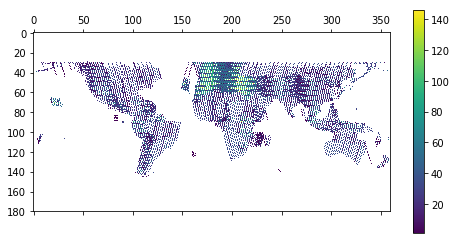

In [11]:
matshow(world_hist); colorbar(); axis('scaled')

In [12]:
# Get the last pair of overlapping tiles found and plot the results
srcs = time_pair_srcs[next(reversed(time_pair_srcs))]
srcs

(<podpac.datalib.smap.SMAPSource at 0x7fa8b1c626a0>,
 <podpac.datalib.smap.SMAPSource at 0x7fa8b1c627f0>)

In [13]:
srcs[0].native_coordinates

Coordinate
	lat: MonotonicCoord: Bounds[-39.397857666015625, -37.082176208496094], N[234], ctype["segment"]
	lon: MonotonicCoord: Bounds[-69.08201599121094, -65.35768127441406], N[360], ctype["segment"]
	time: MonotonicCoord: Bounds[2018-06-01T10:06:55, 2018-06-01T10:06:55], N[1], ctype["segment"]

In [14]:
srcs[1].native_coordinates

Coordinate
	lat: MonotonicCoord: Bounds[-39.307037353515625, -37.082176208496094], N[225], ctype["segment"]
	lon: MonotonicCoord: Bounds[-68.98847961425781, -65.45118713378906], N[342], ctype["segment"]
	time: MonotonicCoord: Bounds[2018-06-01T10:06:55, 2018-06-01T10:06:55], N[1], ctype["segment"]

In [15]:
o0 = srcs[0].execute(srcs[0].native_coordinates)
o1 = srcs[1].execute(srcs[1].native_coordinates)

(-69.27402667999267,
 -65.16568965911866,
 -39.5191873550415,
 -37.077287673950195)

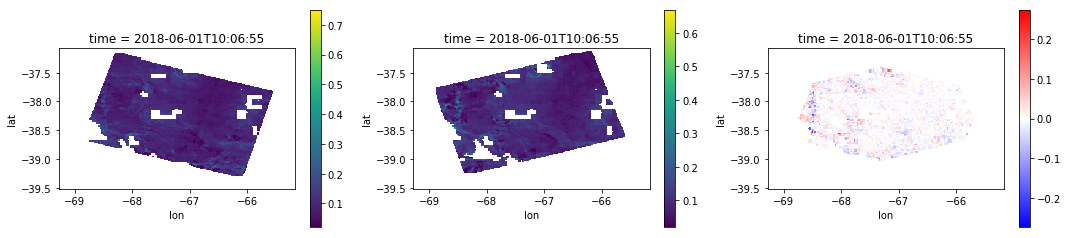

In [16]:
figure(figsize=(18, 4))
ax = subplot(131);                   o0.plot();                axis('scaled')
subplot(132, sharex=ax, sharey=ax);  o1.plot();                axis('scaled')
subplot(133, sharex=ax, sharey=ax); (o0-o1).plot(cmap='bwr');  axis('scaled')